In [2]:
from pathlib import Path
import pandas as pd
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from math import sqrt

In [3]:
# Setup paths
base_path = Path.cwd().resolve().parent.parent
input_path = base_path / "Data" / "traffic_final_dataset.csv"
plots_dir = base_path / "Plots"
plots_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# Load dataset
df = pd.read_csv(input_path, parse_dates=['Timestamp'])
station_id = 400000
df_station = df[df['Station'] == station_id].copy()
df_station = df_station.sort_values('Timestamp')

In [28]:
df_station.head()

,Timestamp,Station,TotalFlow,temp,humidity,precip,visibility,conditions,hour,weekday,month,is_holiday
0,2024-05-01 00:00:00,400000,25,12.0,80.13,0.0,9.9,Clear,0,2,5,False
1,2024-05-01 00:05:00,400000,26,12.0,79.12,0.0,9.9,Clear,0,2,5,False
2,2024-05-01 00:10:00,400000,14,12.8,75.70,0.0,9.9,Clear,0,2,5,False
3,2024-05-01 00:15:00,400000,19,12.7,75.40,0.0,9.9,Clear,0,2,5,False
4,2024-05-01 00:20:00,400000,22,12.7,75.67,0.0,9.3,Clear,0,2,5,False


In [5]:
cols_to_keep = ['Timestamp', 'TotalFlow']
df_station = df_station[cols_to_keep]
df_station.set_index('Timestamp', inplace=True)
df_station.head()

,TotalFlow
Timestamp,
2024-05-01 00:00:00,25
2024-05-01 00:05:00,26
2024-05-01 00:10:00,14
2024-05-01 00:15:00,19
2024-05-01 00:20:00,22


In [6]:
station_data = df_station['TotalFlow']

### Data Exploration

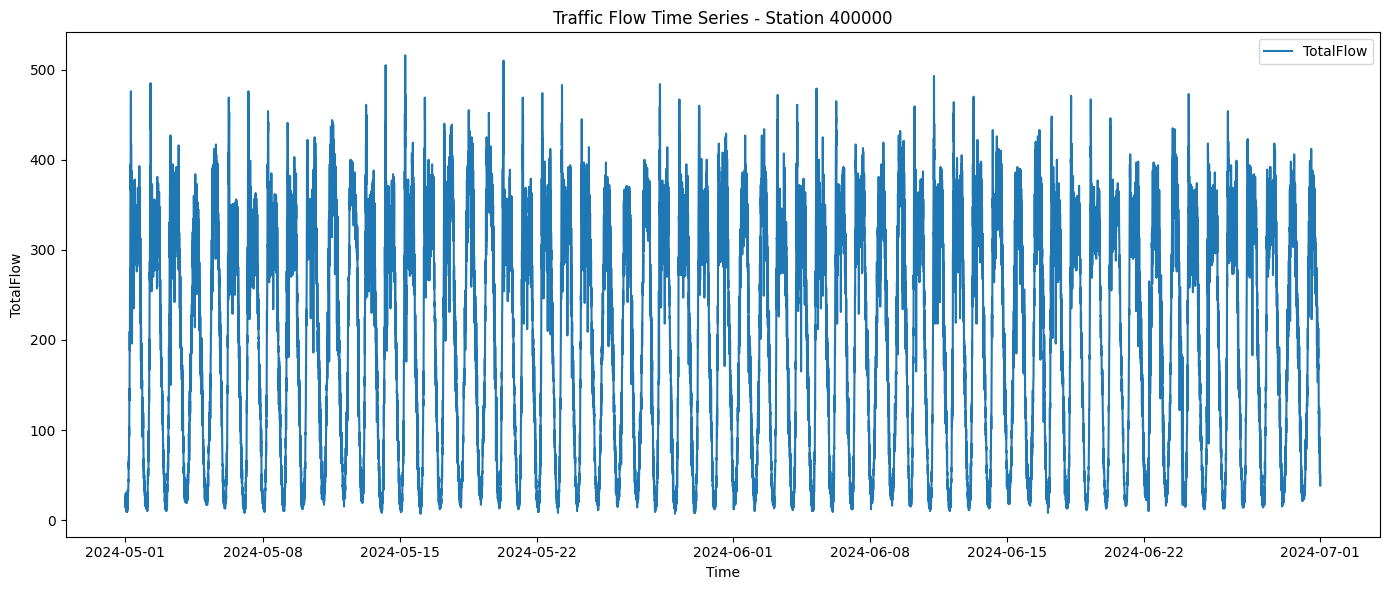

In [49]:
# Plot raw time series
plt.figure(figsize=(14,6))
plt.plot(station_data.index, station_data, label='TotalFlow')
plt.title(f'Traffic Flow Time Series - Station {station_id}')
plt.xlabel('Time')
plt.ylabel('TotalFlow')
plt.legend()
plt.tight_layout()
plt.show()

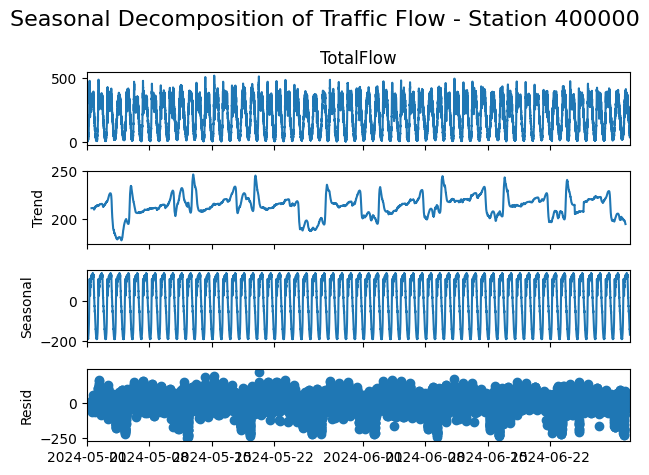

In [54]:
# Seasonal decomposition
# Daily seasonality with 5-minute intervals (12 samples/hour * 24 hours = 288)
decomposition = seasonal_decompose(station_data, model='additive', period=288)

# Plot the decomposition
decomposition.plot()
plt.suptitle(f'Seasonal Decomposition of Traffic Flow - Station {station_id}', fontsize=16)
plt.tight_layout()
plt.show()


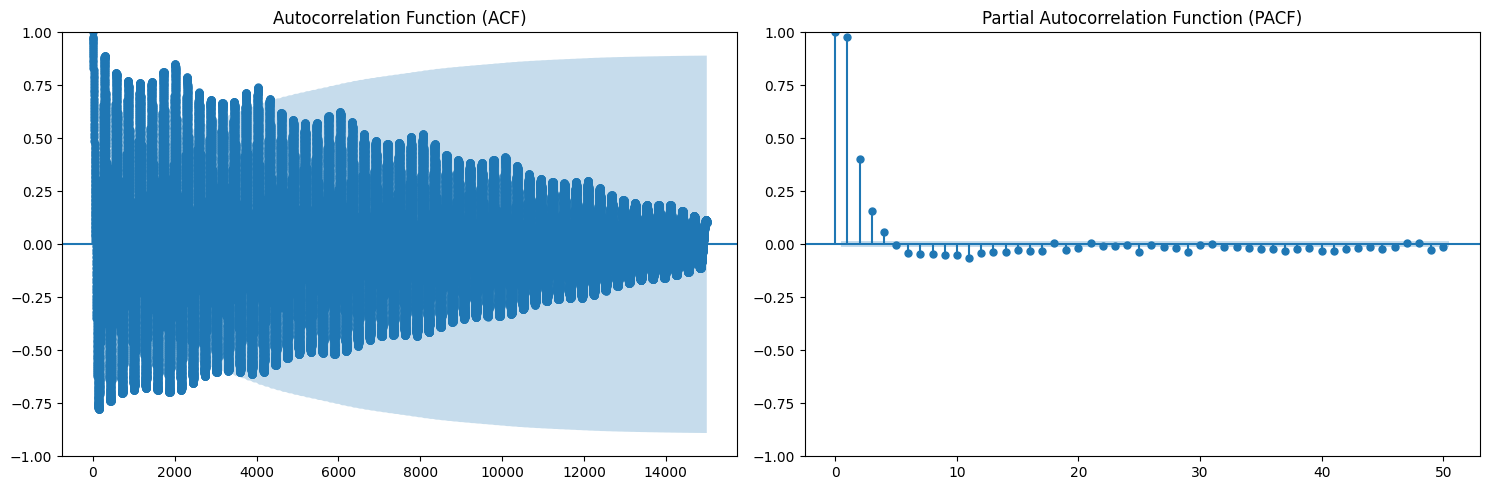

In [64]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15,5))

plot_acf(station_data, lags=15000, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(station_data, lags=50, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [35]:
def check_stationarity(series):
    result = adfuller(series.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] < 0.05:
        print("Series is likely stationary")
    else:
        print("Series is likely non-stationary")

check_stationarity(df_station['TotalFlow'])

ADF Statistic: -16.130107281253437
p-value: 4.7954454718930925e-29
Series is likely stationary


### Model Building

In [75]:
model = pm.auto_arima(
    df_station['TotalFlow'],
    start_p=0,
    start_q=0,
    max_p=5,
    max_q=5,
    d=1,               
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=166990.399, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=163701.844, Time=0.94 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=163243.827, Time=2.92 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=166988.399, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=163175.408, Time=2.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=163162.194, Time=4.91 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=163218.283, Time=1.91 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=163148.524, Time=7.65 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=163146.523, Time=2.83 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=163148.522, Time=1.98 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=162917.649, Time=17.38 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=162872.525, Time=19.84 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=163126.806, Time=3.17 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=162855.844, Time=39.68 sec
 A

In [7]:
def plot_and_save_forecast(station_id, order, horizon_name, y_true, y_pred, timestamps):
    filename = f"Station_{station_id}_ARIMA{order[0]}{order[1]}{order[2]}_{horizon_name}.png"
    filepath = plots_dir / filename
    
    plt.figure(figsize=(12, 5))
    plt.plot(timestamps, y_true, label='Actual')
    plt.plot(timestamps, y_pred, label='Forecast', linestyle='--')
    plt.title(f'Station {station_id} - ARIMA{order} Forecast - {horizon_name} horizon')
    plt.xlabel('Timestamp')
    plt.ylabel('TotalFlow')
    plt.legend()
    plt.tight_layout()
    plt.savefig(filepath)
    plt.show()

In [8]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_idx = y_true != 0
    return np.mean(np.abs((y_true[non_zero_idx] - y_pred[non_zero_idx]) / y_true[non_zero_idx])) * 100

In [9]:
def arima_forecast_evaluate(
    df, station_id, horizon, horizon_name, order, sample_limit=None
):
    # Filter and prepare station data
    df_station = df[df['Station'] == station_id].copy()
    if sample_limit:
        df_station = df_station.sort_values('Timestamp').head(sample_limit).copy()
    
    df_station.set_index('Timestamp', inplace=True)
    df_station = df_station.sort_index().asfreq('5min')
    
    # Select TotalFlow and drop missing
    data = df_station[['TotalFlow']].dropna()
    series = data['TotalFlow'].values
    timestamps = data.index
    
    # 80/20 train-test split
    split_idx = int(len(series) * 0.8)
    train_series, test_series = series[:split_idx], series[split_idx:]
    test_timestamps = timestamps[split_idx:]
    
    history = train_series.tolist()
    predictions = []
    
    # Walk-forward multi-step forecast
    for t in tqdm(range(len(test_series) - horizon + 1), desc=f"Station {station_id} {horizon_name} ARIMA{order}"):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        current_fit = model_fit
        for step in range(horizon):
            yhat = current_fit.forecast()[0]
            if step < horizon - 1:
                current_fit = current_fit.append([yhat], refit=False)
            else:
                current_fit = current_fit.append([test_series[t + step]], refit=False)
        predictions.append(yhat)
        history.append(test_series[t])
    
    preds = np.array(predictions)
    valid_idx = ~np.isnan(preds)
    y_true = test_series[horizon - 1 : horizon - 1 + len(preds)][valid_idx]
    y_pred = preds[valid_idx]
    valid_timestamps = test_timestamps[horizon - 1 : horizon - 1 + len(preds)][valid_idx]
    
    epsilon = 1e-5
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100
    r2 = r2_score(y_true, y_pred)
    
    print(f"Station {station_id}, Horizon {horizon_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%, R²: {r2:.4f}")
    
    plot_and_save_forecast(station_id, order, horizon_name, y_true, y_pred, valid_timestamps)
    
    return {
        'station_id': station_id,
        'horizon_name': horizon_name,
        'order': order,
        'metrics': {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2},
        'y_true': y_true,
        'y_pred': y_pred,
        'timestamps': valid_timestamps
    }


Station 400000 5min ARIMA(3, 1, 4):  38%|██████████████▌                       | 1349/3514 [2:53:09<3:44:42,  6.23s/it]C:\Users\ediso\arima\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Station 400000 5min ARIMA(3, 1, 4):  40%|███████████████▍                      | 1423/3514 [3:01:10<3:35:07,  6.17s/it]C:\Users\ediso\arima\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Station 400000 5min ARIMA(3, 1, 4):  47%|█████████████████▋                    | 1637/3514 [3:24:49<3:17:43,  6.32s/it]C:\Users\ediso\arima\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

Station 400000, Horizon 5min - MAE: 16.39, RMSE: 23.74, MAPE: 10.48%, R²: 0.9665


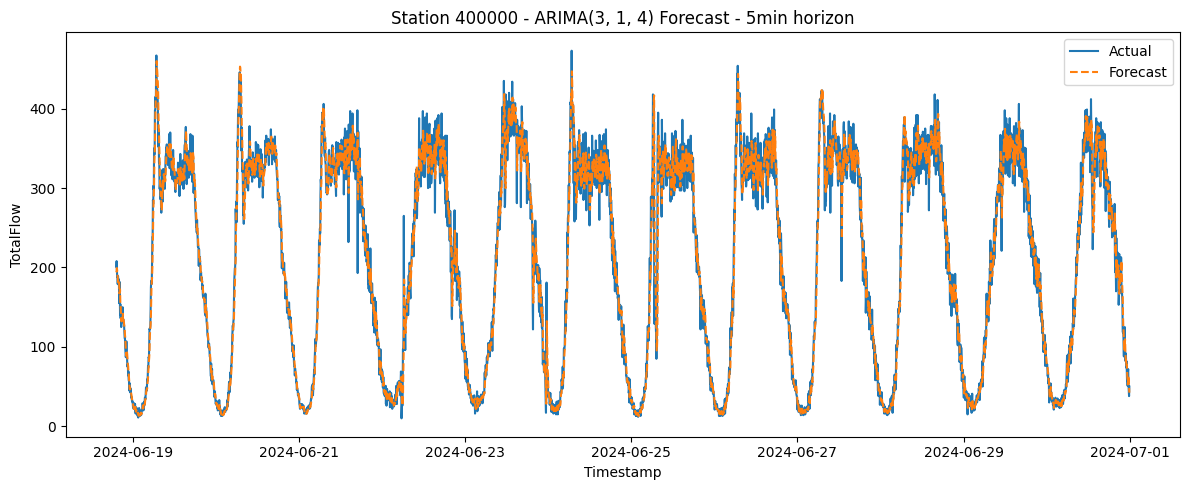

In [10]:
results_5min = arima_forecast_evaluate(
    df,
    station_id=400000,
    horizon=1,
    horizon_name="5min",
    order=(3,1,4),
)

Station 400000 15min ARIMA(3, 1, 4):  38%|██████████████▏                      | 1349/3512 [2:57:42<4:00:16,  6.66s/it]C:\Users\ediso\arima\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Station 400000 15min ARIMA(3, 1, 4):  41%|██████████████▉                      | 1423/3512 [3:06:06<3:48:53,  6.57s/it]C:\Users\ediso\arima\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Station 400000 15min ARIMA(3, 1, 4):  47%|█████████████████▏                   | 1637/3512 [3:30:57<3:27:21,  6.64s/it]C:\Users\ediso\arima\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

Station 400000, Horizon 15min - MAE: 20.03, RMSE: 29.72, MAPE: 12.70%, R²: 0.9474


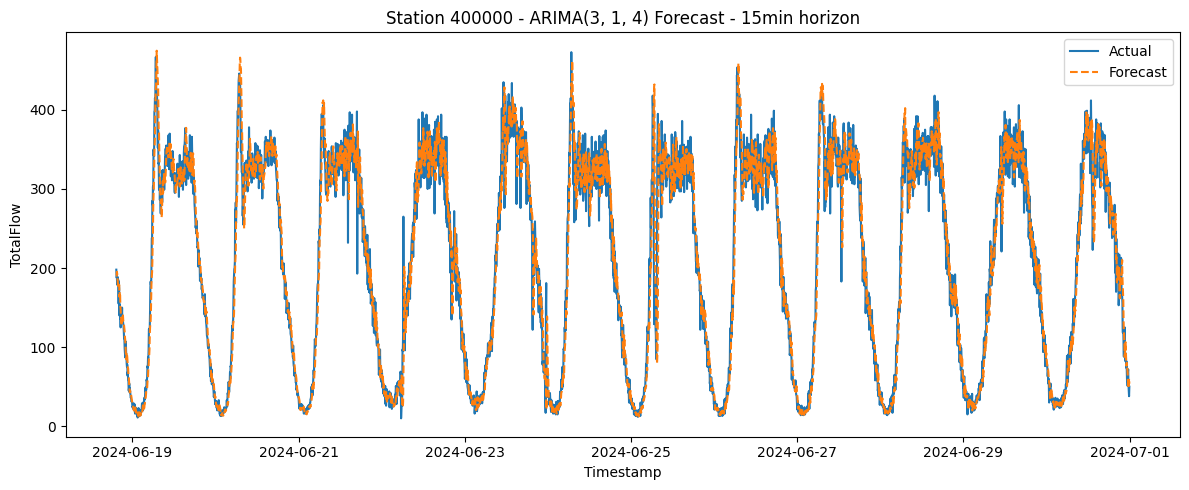

In [11]:
results_15min = arima_forecast_evaluate(
    df,
    station_id=400000,
    horizon=3,
    horizon_name="15min",
    order=(3,1,4),
)

Station 400000 30min ARIMA(3, 1, 4):  38%|██████████████▏                      | 1349/3509 [3:11:10<4:13:07,  7.03s/it]C:\Users\ediso\arima\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Station 400000 30min ARIMA(3, 1, 4):  41%|███████████████                      | 1423/3509 [3:20:16<4:07:45,  7.13s/it]C:\Users\ediso\arima\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Station 400000 30min ARIMA(3, 1, 4):  47%|█████████████████▎                   | 1637/3509 [3:47:05<3:43:46,  7.17s/it]C:\Users\ediso\arima\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

Station 400000, Horizon 30min - MAE: 25.68, RMSE: 38.49, MAPE: 16.01%, R²: 0.9119


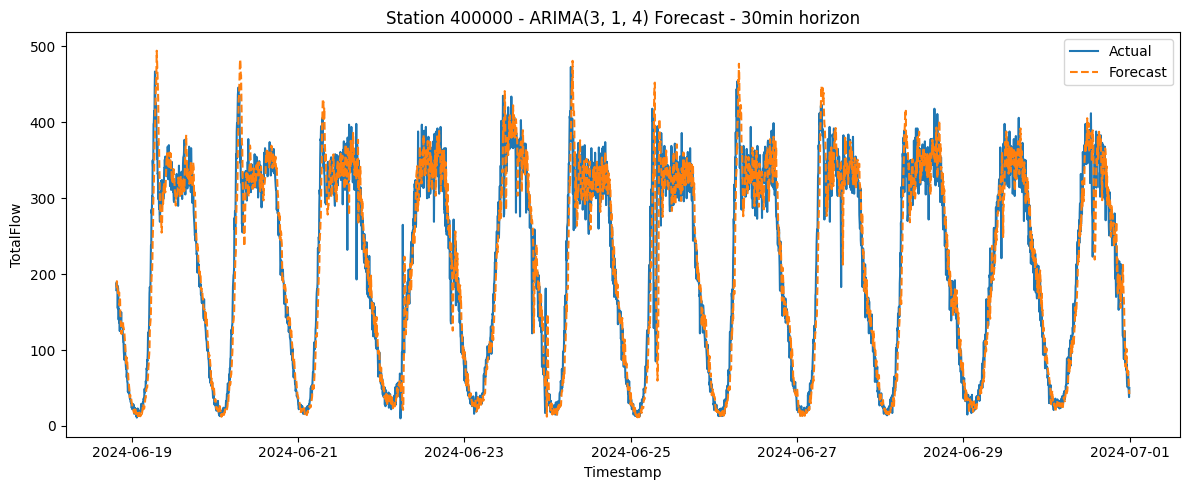

In [13]:
results_30min = arima_forecast_evaluate(
    df,
    station_id=400000,
    horizon=6,
    horizon_name="30min",
    order=(3,1,4),
)